In [2]:
#hide warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Install Libraries
!pip install tmdbv3api cpi pandas numpy scikit-learn seaborn matplotlib shap xgboost requests beautifulsoup4 fake-useragent

# 2. Imports
import pandas as pd
import numpy as np
import cpi
import time
import ast
import itertools
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from tmdbv3api import TMDb, Find, Movie, Discover
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from fake_useragent import UserAgent

# 3. User Configuration
API_KEY = "2408ba3105fdbab4b16bb458113ed558"  # <--- PASTE YOUR KEY HERE
START_YEAR = 2000
END_YEAR = 2025
CURRENT_YEAR = 2025

# 4. Setup API
tmdb = TMDb()
tmdb.api_key = API_KEY
tmdb_movie = Movie()
discover = Discover()

# 5. Suppress CPI Warnings
import logging
logging.getLogger("cpi").setLevel(logging.ERROR)
try: cpi.update()
except: pass

print("Phase 0: Setup Complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 12.8 MB/s eta 0:00:00


Phase 0: Setup Complete.


## **PHASE 1: Target Acquisition (Resilient Scraper)**
**Goal:** Scrape 20,000 high-revenue movies using Time Chunking to bypass API limits.

In [3]:
print("Phase 1: Target Acquisition (Fresh Start)...")

movies_fallback = []
target_count = 20000

# Split into chunks to bypass 10k limit
time_chunks = [
    (START_YEAR, START_YEAR + 12),      # 2000-2012
    (START_YEAR + 13, END_YEAR)         # 2013-2025
]

for start_chunk, end_chunk in time_chunks:
    print(f"Fetching movies for years {start_chunk}-{end_chunk}...")
    page = 1

    while page <= 500 and len(movies_fallback) < target_count:
        try:
            disc = discover.discover_movies({
                'sort_by': 'revenue.desc',
                'primary_release_date.gte': f'{start_chunk}-01-01',
                'primary_release_date.lte': f'{end_chunk}-12-31',
                'with_original_language': 'en',
                'page': page
            })

            if not disc: break

            for m in disc:
                if not any(x['tmdb_id'] == m['id'] for x in movies_fallback):
                    movies_fallback.append({
                        'tmdb_id': m['id'],
                        'release_date': m.get('release_date')
                    })

            if len(movies_fallback) % 1000 == 0:
                print(f"  Progress: {len(movies_fallback)} movies found...")

            page += 1
            time.sleep(0.1)
        except: break

target_df = pd.DataFrame(movies_fallback)
target_df.to_csv('phase1_target_list.csv', index=False)
print(f"\nPhase 1 Complete. {len(target_df)} movies ready.")

Phase 1: Target Acquisition (Fresh Start)...
Fetching movies for years 2000-2012...
  Progress: 1000 movies found...
  Progress: 2000 movies found...
  Progress: 3000 movies found...
Fetching movies for years 2013-2025...

Phase 1 Complete. 19170 movies ready.


## **PHASE 2: Feature Engineering (The Bridge)**
**Goal:** Fetch Metadata.

**Fix:** Saves tmdb_title so we can see movie names later.

In [4]:
print("Phase 2: Feature Engineering...")

final_data = []
skip_low_data = 0

def get_mpaa(releases):
    if not hasattr(releases, 'results'): return 2
    for r in releases.results:
        if r['iso_3166_1'] == 'US':
            for d in r['release_dates']:
                if d['certification']:
                    return {'G':0, 'PG':1, 'PG-13':2, 'R':3, 'NC-17':4}.get(d['certification'], 2)
    return 2

# Iterate through target list
for i, row in target_df.iterrows():
    try:
        m_id = row['tmdb_id']
        details = tmdb_movie.details(m_id, append_to_response='credits,keywords,release_dates')

        budget = getattr(details, 'budget', 0)
        revenue = getattr(details, 'revenue', 0)

        # Filter "Garbage" (Low Budget/Revenue)
        if budget < 1000 or revenue < 1000:
            skip_low_data += 1
            continue

        # Target Calculation (Proxy for Opening Weekend)
        # Global * 40% (Domestic Share) * 35% (First Week Share)
        target_val = revenue * 0.40 * 0.35

        # Feature Extraction
        keywords = [k['name'].lower() for k in list(details.keywords.keywords)] if hasattr(details, 'keywords') else []

        top_cast = []
        director = None
        if hasattr(details, 'credits'):
            if hasattr(details.credits, 'cast'):
                top_cast = [c['id'] for c in list(details.credits.cast)[:3]]
            if hasattr(details.credits, 'crew'):
                director = next((c['id'] for c in list(details.credits.crew) if c['job'] == 'Director'), None)

        is_sequel = 1 if hasattr(details, 'belongs_to_collection') and details.belongs_to_collection else 0
        coll_id = details.belongs_to_collection['id'] if is_sequel else None

        # Inflation Adjustment
        year = pd.to_datetime(details.release_date).year
        try: inf_factor = cpi.inflate(1.0, year, to=CURRENT_YEAR)
        except: inf_factor = 1.0

        final_data.append({
            'tmdb_title': details.title,
            'release_date': pd.to_datetime(details.release_date),
            'Budget_Adj': budget * inf_factor,
            'Domestic_First_Week_Adj': target_val * inf_factor,
            'Runtime': getattr(details, 'runtime', 0),
            'MPAA_Rating': get_mpaa(getattr(details, 'release_dates', None)),
            'Director_ID': director,
            'Top_Cast_IDs': top_cast,
            'Keywords': keywords,
            'Is_Sequel': is_sequel,
            'Collection_ID': coll_id,
            'Distributor_List': list(getattr(details, 'production_companies', []))
        })

    except: pass

    # Progress & Rate Limiting
    if i % 100 == 0:
        print(f"Processed {i}/{len(target_df)}... (Saved: {len(final_data)})")
    time.sleep(0.08)

df = pd.DataFrame(final_data)
df.to_csv('phase2_features.csv', index=False)
print(f"Phase 2 Complete. {len(df)} movies saved.")

Phase 2: Feature Engineering...
Processed 0/19170... (Saved: 1)
Processed 100/19170... (Saved: 101)
Processed 200/19170... (Saved: 201)
Processed 300/19170... (Saved: 301)
Processed 400/19170... (Saved: 401)
Processed 500/19170... (Saved: 500)
Processed 600/19170... (Saved: 600)
Processed 700/19170... (Saved: 699)
Processed 800/19170... (Saved: 798)
Processed 900/19170... (Saved: 897)
Processed 1000/19170... (Saved: 995)
Processed 1100/19170... (Saved: 1091)
Processed 1200/19170... (Saved: 1189)
Processed 1300/19170... (Saved: 1284)
Processed 1400/19170... (Saved: 1382)
Processed 1500/19170... (Saved: 1478)
Processed 1600/19170... (Saved: 1573)
Processed 1700/19170... (Saved: 1663)
Processed 1800/19170... (Saved: 1752)
Processed 1900/19170... (Saved: 1840)
Processed 2000/19170... (Saved: 1925)
Processed 2100/19170... (Saved: 2008)
Processed 2200/19170... (Saved: 2088)
Processed 2300/19170... (Saved: 2164)
Processed 2500/19170... (Saved: 2301)
Processed 2800/19170... (Saved: 2486)
Proce

In [5]:
print("Phase 3: Cleaning & History...")

if 'df' in locals() and not df.empty:
    df = df.sort_values('release_date').reset_index(drop=True)

    # 1. Distributor Processing
    def get_dist_info(comps):
        names = []
        if isinstance(comps, list):
            for c in comps:
                if hasattr(c, 'name'): names.append(c.name)
                elif isinstance(c, dict) and 'name' in c: names.append(c['name'])

        primary = names[0] if names else "Unknown"
        tier = 3
        lower = [n.lower() for n in names]
        if any(k in n for n in lower for k in ['disney', 'warner', 'universal', 'paramount', 'sony', 'marvel', 'pixar']): tier = 1
        elif any(k in n for n in lower for k in ['lionsgate', 'a24', 'netflix', 'dreamworks']): tier = 2
        return pd.Series([primary, tier])

    df[['Distributor_Name', 'Distributor_Tier']] = df['Distributor_List'].apply(get_dist_info)

    # 2. Impute Theater Count
    def estimate_screens(row):
        if row['Distributor_Tier'] == 1: return 4000
        if row['Distributor_Tier'] == 2: return 2500
        return 500
    df['Theater_Count'] = df.apply(estimate_screens, axis=1)

    # 3. Enhanced Genre Engineering
    def check_genre(k_list, targets):
        if isinstance(k_list, list): return 1 if any(t in k_list for t in targets) else 0
        return 0

    df['Genre_SciFi'] = df['Keywords'].apply(lambda x: check_genre(x, ['sci-fi', 'science fiction', 'alien', 'future', 'space']))
    df['Genre_Adventure'] = df['Keywords'].apply(lambda x: check_genre(x, ['adventure', 'journey', 'quest']))
    df['Genre_Action'] = df['Keywords'].apply(lambda x: check_genre(x, ['action', 'war', 'battle', 'fight']))
    df['Genre_Fantasy'] = df['Keywords'].apply(lambda x: check_genre(x, ['fantasy', 'magic', 'myth', 'creature', 'monster']))
    df['Has_IMAX_3D'] = df['Keywords'].apply(lambda x: check_genre(x, ['3d', 'imax']))
    df['Release_Month'] = df['release_date'].dt.month

    # 4. Rolling History Loop (Time Travel Safe)
    dir_hist, cast_hist, collab_graph = {}, {}, {}
    c_dir, c_cast, c_fam, c_prev, c_comp = [], [], [], [], []

    for idx, row in df.iterrows():
        # Competition Score
        start, end = row['release_date'] - timedelta(days=7), row['release_date'] + timedelta(days=7)
        c_comp.append(max(0, df[(df['release_date'] >= start) & (df['release_date'] <= end)].shape[0] - 1))

        # Sequel History
        prev = 0
        if row['Is_Sequel'] and row['Collection_ID']:
            sibs = df[(df['Collection_ID'] == row['Collection_ID']) & (df['release_date'] < row['release_date'])]
            if not sibs.empty: prev = sibs.iloc[-1]['Domestic_First_Week_Adj']
        c_prev.append(prev)

        # Star Power
        c_dir.append(dir_hist.get(row['Director_ID'], 0))
        c_cast.append(sum([cast_hist.get(a, 0) for a in row['Top_Cast_IDs']]))

        # Familiarity
        fam = 0
        if len(row['Top_Cast_IDs']) > 1:
            for pair in itertools.combinations(row['Top_Cast_IDs'], 2):
                fam += collab_graph.get(frozenset(pair), 0)
        c_fam.append(fam)

        # Update Trackers
        rev = row['Domestic_First_Week_Adj']
        if row['Director_ID']: dir_hist[row['Director_ID']] = dir_hist.get(row['Director_ID'], 0) + rev
        for a in row['Top_Cast_IDs']: cast_hist[a] = cast_hist.get(a, 0) + rev
        if len(row['Top_Cast_IDs']) > 1:
            for pair in itertools.combinations(row['Top_Cast_IDs'], 2):
                key = frozenset(pair)
                collab_graph[key] = collab_graph.get(key, 0) + 1

    df['Competition_Score'] = c_comp
    df['Prev_Movie_Gross_Adj'] = c_prev
    df['Director_Prev_Gross'] = c_dir
    df['Cast_Star_Power'] = c_cast
    df['Actor_Familiarity'] = c_fam

    # 5. Imputation & Save
    mask = (df['Is_Sequel'] == 1) & (df['Prev_Movie_Gross_Adj'] == 0)
    if mask.sum() > 0:
        ratio = (df['Prev_Movie_Gross_Adj'] / df['Budget_Adj']).median()
        df.loc[mask, 'Prev_Movie_Gross_Adj'] = df.loc[mask, 'Budget_Adj'] * (ratio if not np.isnan(ratio) else 3.0)

    df.to_csv('Avatar_Final_Dataset_Enhanced.csv', index=False)
    print("Phase 3 Complete. Dataset Saved.")

Phase 3: Cleaning & History...
Phase 3 Complete. Dataset Saved.


In [13]:
# ==========================================
# DOWNLOAD THE DATASET
# ==========================================
from google.colab import files

try:
    print("Downloading 'Avatar_Final_Dataset_Enhanced.csv'...")
    files.download('Avatar_Final_Dataset_Enhanced.csv')
except ImportError:
    print("Error: This download code only works in Google Colab.")
    print("If you are running locally, the file is already in your folder.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Phase 4: Modeling (Log-Transformed)...
Data Cleaned: 5649 -> 5303 rows.
------------------------------
MAE: $7,883,280
R2:  0.6057
------------------------------


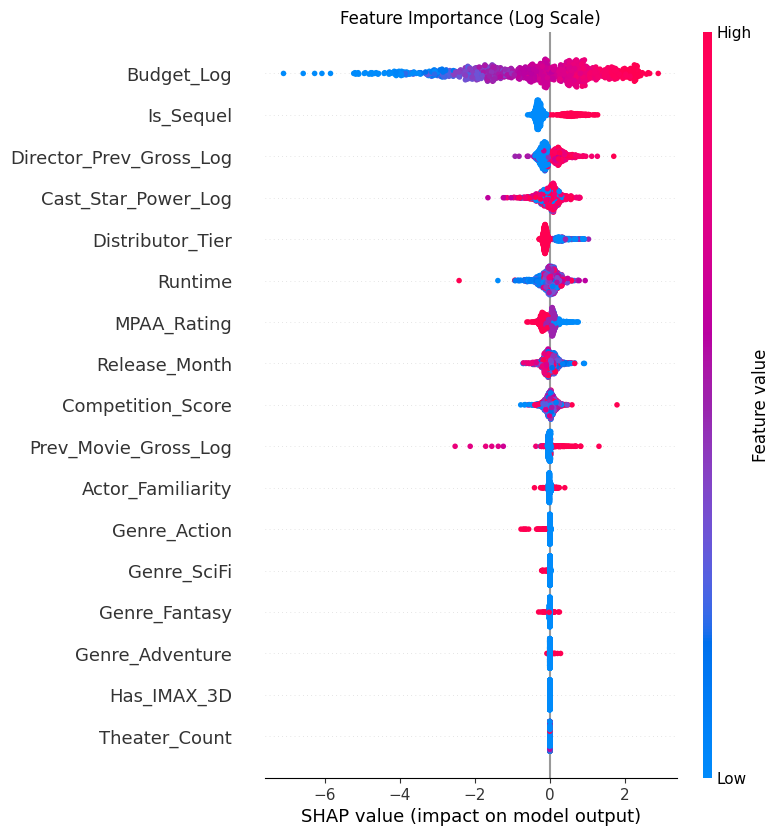

In [8]:
print("Phase 4: Modeling (Log-Transformed)...")

df_final = pd.read_csv('Avatar_Final_Dataset_Enhanced.csv')

# 1. CRITICAL: Runtime Filter (Source 159)
# Remove shorts (<60 mins) and micro-budget films
df_clean = df_final[(df_final['Runtime'] >= 60) & (df_final['Budget_Adj'] > 10000)].copy()
print(f"Data Cleaned: {len(df_final)} -> {len(df_clean)} rows.")

# 2. CRITICAL: Log Transforms (Prevent Exploding Gradients)
# Apply logs to ALL large financial numbers
df_clean['Budget_Log'] = np.log1p(df_clean['Budget_Adj'])
df_clean['Target_Log'] = np.log1p(df_clean['Domestic_First_Week_Adj'])
df_clean['Prev_Movie_Gross_Log'] = np.log1p(df_clean['Prev_Movie_Gross_Adj'])
df_clean['Director_Prev_Gross_Log'] = np.log1p(df_clean['Director_Prev_Gross']) # <--- NEW
df_clean['Cast_Star_Power_Log'] = np.log1p(df_clean['Cast_Star_Power'])         # <--- NEW

# 3. Define Features (No Leakage)
features = [
    'Budget_Log', 'Release_Month', 'Competition_Score', 'Is_Sequel', 'Prev_Movie_Gross_Log',
    'Runtime', 'Distributor_Tier', 'Theater_Count',
    'Director_Prev_Gross_Log', 'Cast_Star_Power_Log', # <--- USING LOGGED VERSIONS
    'Actor_Familiarity', 'MPAA_Rating',
    'Genre_SciFi', 'Genre_Adventure', 'Genre_Action', 'Genre_Fantasy', 'Has_IMAX_3D'
]

X = df_clean[features]
y = df_clean['Target_Log']

# 4. Weights (Prioritize Blockbusters)
weights = np.ones(len(X))
if 'Genre_SciFi' in X.columns: weights[X['Genre_SciFi'] == 1] *= 2.0
if 'Is_Sequel' in X.columns:   weights[X['Is_Sequel'] == 1] *= 1.5
weights[X['Budget_Log'] > np.log1p(150_000_000)] *= 3.0

# 5. Train XGBoost
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
model.fit(X_train, y_train, sample_weight=w_train)

# 6. Evaluate (Real Dollars)
# We must use expm1 to reverse the log transform
preds = np.expm1(model.predict(X_test))
actuals = np.expm1(y_test)

print("-" * 30)
print(f"MAE: ${mean_absolute_error(actuals, preds):,.0f}")
print(f"R2:  {r2_score(actuals, preds):.4f}")
print("-" * 30)

# Visualize
plt.figure(figsize=(10,5))
shap.summary_plot(shap.Explainer(model)(X_test), X_test, show=False)
plt.title("Feature Importance (Log Scale)")
plt.show()

In [10]:
# ==========================================
# SAVE & DOWNLOAD FINAL TRAINING DATA (Phase 4 Output)
# ==========================================
from google.colab import files

# Define the filename for the clean, log-transformed data
training_filename = 'Avatar_Training_Data_Ready.csv'

# Check if the clean dataframe from Phase 4 exists
if 'df_clean' in locals():
    print(f"Saving cleaned dataset ({len(df_clean)} rows) to CSV...")

    # Save to local Colab storage
    df_clean.to_csv(training_filename, index=False)

    print(f"✅ Success! Saved as '{training_filename}'")

    # Trigger Download
    try:
        files.download(training_filename)
        print("📥 Download started...")
    except ImportError:
        print("Error: Download only works in Google Colab. File is saved locally.")
else:
    print("❌ Error: 'df_clean' not found. Please run the Phase 4 block first.")

Saving cleaned dataset (5303 rows) to CSV...
✅ Success! Saved as 'Avatar_Training_Data_Ready.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Download started...
